In [ ]:
import sys
import math
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as f
import torchvision
import numpy as np
import copy
import os
from torchvision import datasets, models, transforms
from pathlib import Path
from functools import partial
from typing import Iterable, Tuple, Union,Callable, NamedTuple,Dict, Iterable, List, Optional, Sequence, Union, Any, cast
import torch
import torch.nn as nn
from torch import Tensor, nn
import torch.optim as optim
from torch.fft import irfftn, rfftn
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
  details = tf.config.experimental.get_device_details(gpu_devices[0])
  details.get('device_name', 'Unknown GPU')
print(details)

{'compute_capability': (8, 0), 'device_name': 'A100-SXM4-40GB'}


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def complex_matmul(a: Tensor, b: Tensor) -> Tensor:
    #doing complex multiplication
    scalar_matmul = partial(torch.einsum, "ab..., cb... -> ac...")
    real_part = scalar_matmul(a.real, b.real) - scalar_matmul(a.imag, b.imag)
    imag_part = scalar_matmul(a.imag, b.real) + scalar_matmul(a.real, b.imag)
    result = torch.zeros(real_part.shape, dtype=torch.complex64, device=a.device)
    result.real, result.imag = real_part, imag_part
    return result
def my_fft_conv(
    image: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding = 0,
) -> Tensor:

    # convert into tuple
    padding = (image.ndim - 2) * (0,)

    # Pad the tensors
    image_padding = [p for p in padding[::-1] for _ in range(2)]
    image = f.pad(image, image_padding)

    if image.size(-1) % 2 != 0:
        image_ = f.pad(image, [0, 1])
    else:
        image_ = image
    # Padding for kernel
    kernel_padding = [pad for i in reversed(range(2, image_.ndim)) for pad in [0, image_.size(i) - kernel.size(i)]]
    padded_kernel = f.pad(kernel, kernel_padding)

    # fourier convolution
    dim = tuple(range(2, image.ndim))
    image_ = image_.to(device)
    padded_kernel = padded_kernel.to(device)
    bias = bias.to(device)
    #FFT
    image_fft = rfftn(image_, dim=dim)
    kernel_fft = rfftn(padded_kernel, dim=dim)
    #complex mutiplication
    kernel_fft.imag *= -1
    output_fft = complex_matmul(image_fft, kernel_fft)
    #inverse FFT
    output = irfftn(output_fft, dim=dim)

    # Remove extra padded values
    crop_slices = [slice(0, output.size(0)), slice(0, output.size(1))] + [
        slice(0, (image.size(i) - kernel.size(i) + 1))
        for i in range(2, image.ndim)
    ]
    output = output[crop_slices].contiguous()

    # add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (image.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output
class FFTConv2d(nn.Module):
    """FFT convolution layers."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding = 0,
        bias: bool = True,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.use_bias = bias

        #convert to a tuple
        kernel_size = 2 * (kernel_size,)
        weight = torch.randn(out_channels, in_channels, *kernel_size)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def forward(self, image):
        return my_fft_conv(
            image,
            self.weight,
            bias=self.bias,
            padding=self.padding,
        )
import numpy as np

def naive_conv2d(image, kernel, bias, stride=1, padding=0):
  # Get the dimensions of the input image, kernel, and bias
  batch_size, input_channel, input_height, input_width = image.shape
  output_channel, input_channel, kernel_height, kernel_width = kernel.shape
  output_channel, = bias.shape

  # Calculate the size of the output image
  output_height = (input_height - kernel_height + 2 * padding) // stride + 1
  output_width = (input_width - kernel_width + 2 * padding) // stride + 1

  # Create a zero-initialized array to store the convolved image
  result = torch.zeros(batch_size, output_channel, output_height, output_width)

  # Iterate over the batch
  for b in range(batch_size):
    # Iterate the output image
    for o in range(output_channel):
      # Iterateeach position in the output image
      for h in range(output_height):
        for w in range(output_width):
          # Calculate the start and end positions of the kernel
          # on the input image
          h_start = h * stride
          h_end = h_start + kernel_height
          w_start = w * stride
          w_end = w_start + kernel_width

          image = image.to(device)
          kernel = kernel.to(device)
          result = result.to(device)

          input_subarray = image[b, :, h_start:h_end, w_start:w_end]

          # Compute the dot product of the subarray with the kernel
          # add bias
          result[b, o, h, w] = torch.sum(input_subarray * kernel[o]) + bias[o]

  return result


In [ ]:
class NaiveConv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding = 0,
        bias: bool = True,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.use_bias = bias

        #convert to a tuple
        kernel_size = 2 * (kernel_size,)
        weight = torch.randn(out_channels, in_channels, *kernel_size)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None
    def forward(self, image):
        return naive_conv2d(
            image,
            self.weight,
            bias=self.bias,
        )

In [ ]:
class Net(nn.Module):
  # using nn.Conv2d
    def __init__(self, input_size, kernel_size):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3,16,kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        fc1_input = (math.floor((input_size - kernel_size + 1 ) / 2) **2) * 16
        self.fc1 = nn.Linear(fc1_input, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class FFT_Net(nn.Module):
    def __init__(self, input_size, kernel_size):
        super().__init__()
        self.conv1 = FFTConv2d(3,16,kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        #update the input size for the first linear layer
        fc_input = (math.floor((input_size - kernel_size + 1 ) / 2) **2) * 16
        self.fc1 = nn.Linear(fc_input, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class NaiveNet(nn.Module):
    def __init__(self, input_size, kernel_size):
        super().__init__()
        fc1_size = (math.floor((input_size - kernel_size + 1 ) / 2) **2) * 16
        self.conv1 = NaiveConv2d(3, 16, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(fc1_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#Test for Net
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Net_updateoutput = []
Net_updateGradInput = []
Net_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 60
NUM_RUNS = 2
input_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))
# loop over the dataset multiple times
for input in tqdm(input_size_list):
    trainset = torchvision.datasets.FakeData(size=1, image_size=(3,
            input, input), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=1, shuffle=True, num_workers=2)
    net = Net(input,3)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    Net_updateoutput.append(t_out/NUM_RUNS)
    Net_updateGradInput.append(t_gradinput/NUM_RUNS)
    Net_accGradParameters.append(t_gradparameters/NUM_RUNS)

net.to("cpu")
del net


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


In [ ]:
#Test for FFT net
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

FFT_updateoutput = []
FFT_updateGradInput = []
FFT_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 60
NUM_RUNS = 2
input_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))
# loop over the dataset multiple times
for input in tqdm(input_size_list):
    trainset = torchvision.datasets.FakeData(size=1, image_size=(3,
            input, input), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=1, shuffle=True, num_workers=2)
    FFT_net = FFT_Net(input,3)
    FFT_net.to(device)
    optimizer = optim.SGD(FFT_net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer = optim.SGD(FFT_net.parameters(), lr=0.001, momentum=0.9)
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= FFT_net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    FFT_updateoutput.append(t_out/NUM_RUNS)
    FFT_updateGradInput.append(t_gradinput/NUM_RUNS)
    FFT_accGradParameters.append(t_gradparameters/NUM_RUNS)

FFT_net.to("cpu")
del FFT_net


100%|██████████| 11/11 [00:03<00:00,  3.21it/s]


In [ ]:
#Test for the Naive Net
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Naive_updateoutput = []
Naive_updateGradInput = []
Naive_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 60
NUM_RUNS = 2
input_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))

# loop over the dataset multiple times
for input in tqdm(input_size_list):
    trainset = torchvision.datasets.FakeData(size=1, image_size=(3,
            input, input), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=1, shuffle=True, num_workers=2)

    Naive_Net = NaiveNet(input,3)
    Naive_Net.to(device)
    optimizer = optim.SGD(Naive_Net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= Naive_Net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    Naive_updateoutput.append(t_out/NUM_RUNS)
    Naive_updateGradInput.append(t_gradinput/NUM_RUNS)
    Naive_accGradParameters.append(t_gradparameters/NUM_RUNS)

Naive_Net.to("cpu")
del Naive_Net


100%|██████████| 11/11 [01:20<00:00,  7.36s/it]


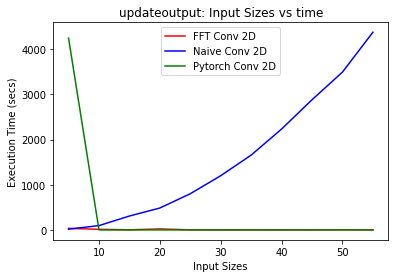

In [ ]:
## Plotting for input size vs running times
plt.plot(input_size_list, FFT_updateoutput, label='FFT Conv 2D', color='red')
plt.plot(input_size_list, Naive_updateoutput, label='Naive Conv 2D', color='blue')
plt.plot(input_size_list, Net_updateoutput, label='Pytorch Conv 2D', color='green')

plt.xlabel('Input Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("updateoutput: Input Sizes vs time")
plt.show()

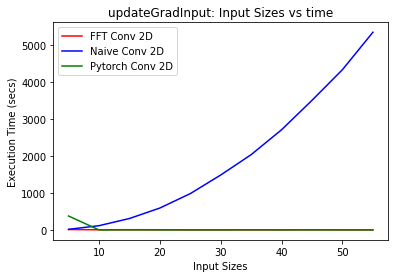

In [ ]:
plt.plot(input_size_list, FFT_updateGradInput, label='FFT Conv 2D', color='red')
plt.plot(input_size_list, Naive_updateGradInput, label='Naive Conv 2D', color='blue')
plt.plot(input_size_list, Net_updateGradInput, label='Pytorch Conv 2D', color='green')


plt.xlabel('Input Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("updateGradInput: Input Sizes vs time")
plt.show()

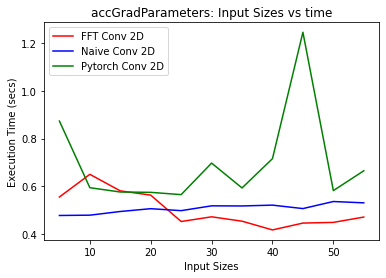

In [ ]:
plt.plot(input_size_list, FFT_accGradParameters, label='FFT Conv 2D', color='red')
plt.plot(input_size_list, Naive_accGradParameters, label='Naive Conv 2D', color='blue')
plt.plot(input_size_list, Net_accGradParameters, label='Pytorch Conv 2D', color='green')

plt.xlabel('Input Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("accGradParameters: Input Sizes vs time")
plt.show()

In [ ]:
#Test for net Kernel Size
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Net_updateoutput = []
Net_updateGradInput = []
Net_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 50
NUM_RUNS = 2
kernel_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))

# loop over the dataset multiple times
for kernel_size in tqdm(kernel_size_list):
    trainset = torchvision.datasets.FakeData(size=1, image_size=(3,
            100, 100), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=1, shuffle=True, num_workers=2)
    net = Net(100,kernel_size,)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    Net_updateoutput.append(t_out/NUM_RUNS)
    Net_updateGradInput.append(t_gradinput/NUM_RUNS)
    Net_accGradParameters.append(t_gradparameters/NUM_RUNS)

net.to("cpu")
del net


100%|██████████| 9/9 [00:03<00:00,  2.50it/s]


In [ ]:
#Test for FFT net Kernel Size
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

FFT_updateoutput = []
FFT_updateGradInput = []
FFT_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 50
NUM_RUNS = 2
kernel_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))

# loop over the dataset multiple times
for kernel_size in tqdm(kernel_size_list):
    trainset = torchvision.datasets.FakeData(size=1, image_size=(3,
            100, 100), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=1, shuffle=True, num_workers=2)
    FFT_net = FFT_Net(100,kernel_size,)
    FFT_net.to(device)
    optimizer = optim.SGD(FFT_net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= FFT_net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    FFT_updateoutput.append(t_out/NUM_RUNS)
    FFT_updateGradInput.append(t_gradinput/NUM_RUNS)
    FFT_accGradParameters.append(t_gradparameters/NUM_RUNS)

FFT_net.to("cpu")
del FFT_net


100%|██████████| 9/9 [00:02<00:00,  3.01it/s]


In [ ]:
#Test for the Naive Net
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Naive_updateoutput = []
Naive_updateGradInput = []
Naive_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 50
NUM_RUNS = 2
kernel_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,5 ))

# loop over the dataset multiple times
for kernel_size in tqdm(kernel_size_list):
    trainset = torchvision.datasets.FakeData(size=1, image_size=(3,
            100, 100), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=1, shuffle=True, num_workers=2)

    Naive_Net = NaiveNet(100,kernel_size)
    Naive_Net.to(device)
    optimizer = optim.SGD(Naive_Net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= Naive_Net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    Naive_updateoutput.append(t_out/NUM_RUNS)
    Naive_updateGradInput.append(t_gradinput/NUM_RUNS)
    Naive_accGradParameters.append(t_gradparameters/NUM_RUNS)

Naive_Net.to("cpu")
del Naive_Net


100%|██████████| 9/9 [06:18<00:00, 42.11s/it]


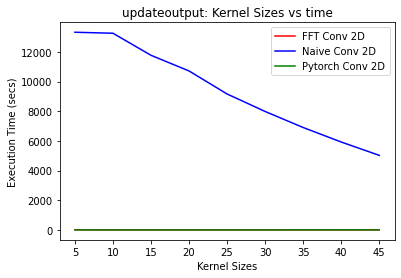

In [ ]:
## Plotting for input size vs running times
plt.plot(kernel_size_list, FFT_updateoutput, label='FFT Conv 2D', color='red')
plt.plot(kernel_size_list, Naive_updateoutput, label='Naive Conv 2D', color='blue')
plt.plot(kernel_size_list, Net_updateoutput, label='Pytorch Conv 2D', color='green')
plt.xlabel('Kernel Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("updateoutput: Kernel Sizes vs time")
plt.show()

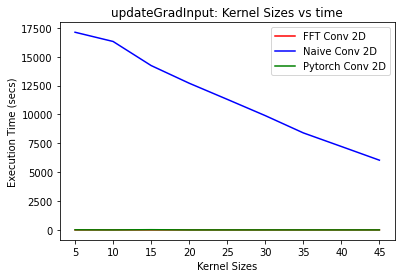

In [ ]:
plt.plot(kernel_size_list, FFT_updateGradInput, label='FFT Conv 2D', color='red')
plt.plot(kernel_size_list, Naive_updateGradInput, label='Naive Conv 2D', color='blue')
plt.plot(kernel_size_list, Net_updateGradInput, label='Pytorch Conv 2D', color='green')
plt.xlabel('Kernel Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("updateGradInput: Kernel Sizes vs time")
plt.show()

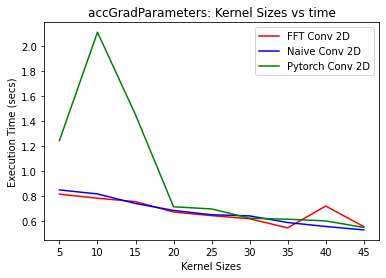

In [ ]:
plt.plot(kernel_size_list, FFT_accGradParameters, label='FFT Conv 2D', color='red')
plt.plot(kernel_size_list, Naive_accGradParameters, label='Naive Conv 2D', color='blue')
plt.plot(kernel_size_list, Net_accGradParameters, label='Pytorch Conv 2D', color='green')
plt.xlabel('Kernel Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("accGradParameters: Kernel Sizes vs time")
plt.show()

In [ ]:
#Test for net Batch Size
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Net_updateoutput = []
Net_updateGradInput = []
Net_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 10
NUM_RUNS = 2
Batch_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,1 ))

# loop over the dataset multiple times
for batch_size in tqdm(Batch_size_list):
    trainset = torchvision.datasets.FakeData(size=batch_size, image_size=(3,
            100, 100), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)
    net = Net(100,3,)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    Net_updateoutput.append(t_out/NUM_RUNS)
    Net_updateGradInput.append(t_gradinput/NUM_RUNS)
    Net_accGradParameters.append(t_gradparameters/NUM_RUNS)

net.to("cpu")
del net


100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


In [ ]:
#Test for FFT net Batch Size
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

FFT_updateoutput = []
FFT_updateGradInput = []
FFT_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 10
NUM_RUNS = 2
Batch_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,1 ))

# loop over the dataset multiple times
for batch_size in tqdm(Batch_size_list):
    trainset = torchvision.datasets.FakeData(size=batch_size, image_size=(3,
            100, 100), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)
    FFT_net = FFT_Net(100,3,)
    FFT_net.to(device)
    optimizer = optim.SGD(FFT_net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= FFT_net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    FFT_updateoutput.append(t_out/NUM_RUNS)
    FFT_updateGradInput.append(t_gradinput/NUM_RUNS)
    FFT_accGradParameters.append(t_gradparameters/NUM_RUNS)

FFT_net.to("cpu")
del FFT_net


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


In [ ]:
#Test for the Naive Net Batch Size
criterion = nn.CrossEntropyLoss() # TODO create criterion

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

Naive_updateoutput = []
Naive_updateGradInput = []
Naive_accGradParameters = []

MIN_INPUT_SIZE  = 5
MAX_INPUT_SIZE = 10
NUM_RUNS = 2
Batch_size_list = list(range(MIN_INPUT_SIZE, MAX_INPUT_SIZE,1 ))

# loop over the dataset multiple times
for batch_size in tqdm(Batch_size_list):
    trainset = torchvision.datasets.FakeData(size=batch_size, image_size=(3,
            100, 100), transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
            batch_size=batch_size, shuffle=True, num_workers=2)

    Naive_Net = NaiveNet(100,3)
    Naive_Net.to(device)
    optimizer = optim.SGD(Naive_Net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer
    t_out = 0
    t_gradinput = 0
    t_gradparameters = 0
    for epoch in range(NUM_RUNS):
      for i, (inputs, labels) in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        (inputs, labels) = (inputs.to(device), labels.to(device))


      #### training of CNN model using FFT 2D Conv Layer

          # zero the parameter gradients
        optimizer.zero_grad()

        # timing update of output
        start.record()
        outputs= Naive_Net(inputs)
        end.record()
        torch.cuda.synchronize()
        t_out += start.elapsed_time(end)
        # timing the update of gradient input
        start.record()
        loss = criterion(outputs, labels)
        loss.backward()
        end.record()
        torch.cuda.synchronize()
        t_gradinput += start.elapsed_time(end)
        # timing the update of gradient parameters
        start.record()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        t_gradparameters += start.elapsed_time(end)

    Naive_updateoutput.append(t_out/NUM_RUNS)
    Naive_updateGradInput.append(t_gradinput/NUM_RUNS)
    Naive_accGradParameters.append(t_gradparameters/NUM_RUNS)

Naive_Net.to("cpu")
del Naive_Net


100%|██████████| 5/5 [43:40<00:00, 524.19s/it]


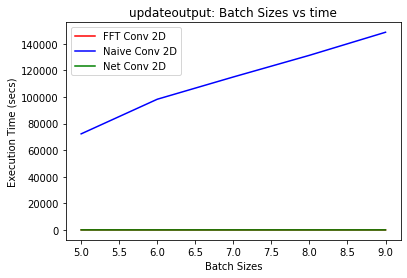

In [ ]:
## Plotting for batch size vs running times
plt.plot(Batch_size_list, FFT_updateoutput, label='FFT Conv 2D', color='red')
plt.plot(Batch_size_list, Naive_updateoutput, label='Naive Conv 2D', color='blue')
plt.plot(Batch_size_list, Net_updateoutput, label='Net Conv 2D', color='green')

plt.xlabel('Batch Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("updateoutput: Batch Sizes vs time")
plt.show()

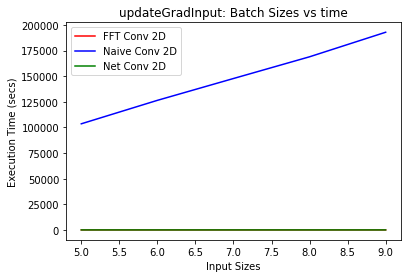

In [ ]:
plt.plot(Batch_size_list, FFT_updateGradInput, label='FFT Conv 2D', color='red')
plt.plot(Batch_size_list, Naive_updateGradInput, label='Naive Conv 2D', color='blue')
plt.plot(Batch_size_list, Net_updateGradInput, label='Net Conv 2D', color='green')

plt.xlabel('Input Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("updateGradInput: Batch Sizes vs time")
plt.show()

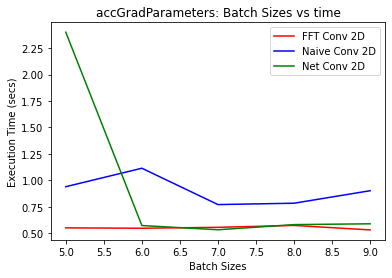

In [ ]:
plt.plot(Batch_size_list, FFT_accGradParameters, label='FFT Conv 2D', color='red')
plt.plot(Batch_size_list, Naive_accGradParameters, label='Naive Conv 2D', color='blue')
plt.plot(Batch_size_list, Net_accGradParameters, label='Net Conv 2D', color='green')

plt.xlabel('Batch Sizes')
plt.ylabel('Execution Time (secs)')
plt.legend()
plt.title("accGradParameters: Batch Sizes vs time")
plt.show()